In [1]:
%pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=ca43d10449c8a3fb174e08ce6340927e24d6ad66298ad9a688cc4a2462d65b06
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [2]:
import pyod
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pyod.utils.data import generate_data
from pyod.models.ocsvm import OCSVM
from pyod.models.deep_svdd import DeepSVDD

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import confusion_matrix

class Metrics:
    @staticmethod
    def balanced_accuracy(labels: np.ndarray, predictions: np.ndarray) -> float:
        tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

        # compute recall, sensitivity
        tpr = tp / (tp + fn)
        # compute specificity
        tnr = tn / (tn + fp)
        # compute balanced accuracy
        ba = (tpr + tnr) / 2

        return ba

# **Exercise 1:**

1. In the first exercise you will use **generate data()** function **from pyod.utils.data** to generate a 3-dimensional dataset with 300 training samples and 200 test samples using a contamination of 0.15.

2. You will fit an **OCSVM** model (from **pyod.models.ocsvm**) using the
training data and then you will predict the labels for test data. Use the
linear kernel and the contamination rate specified above. Compute the
balanced accuracy and the ROC AUC for the test data.

3. Create 4 3D subplots where you will plot the test and training data (using
different colors for inliers and outliers) for both the ground truth and the
predicted labels.

4. Observe how the predicted labels change when you use an RBF kernel.

5. Perform steps 2 and 3 for **DeepSVDD** model from **pyod.models.deep_svdd**


In [5]:
contamination=0.45
n_train=500
n_test=300
n_features=3

train_data, test_data, train_labels, test_labels = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features=n_features,
    contamination=contamination,
)

In [6]:
ocsvm_linear = OCSVM(kernel='linear', contamination=contamination)
ocsvm_linear.fit(train_data)

# extract labels for training data
ocsvm_linear_train_predictions = ocsvm_linear.labels_
# extract score for training data
ocsvm_linear_train_scores = ocsvm_linear.decision_scores_

In [7]:
# compute predictions for the testing data
ocsvm_linear_test_predictions = ocsvm_linear.predict(test_data)
# compute scores for the testing data
ocsvm_linear_test_scores = ocsvm_linear.decision_function(test_data)

# compute balanced accuracy and ROC AUC score
ocsvm_linear_test_ba = Metrics.balanced_accuracy(test_labels, ocsvm_linear_test_predictions)
ocsvm_linear_test_roc_auc = roc_auc_score(test_labels, ocsvm_linear_test_scores)

print(f"Test BA for Linear OCSVM: {ocsvm_linear_test_ba:.5f}")
print(f"Test ROC AUC for Linear OCSVM: {ocsvm_linear_test_roc_auc:.5f}")

Test BA for Linear OCSVM: 0.99697
Test ROC AUC for Linear OCSVM: 1.00000


In [8]:
def plot_3d_comparison(
    train_data: np.ndarray,
    train_labels: np.ndarray,
    test_data: np.ndarray,
    test_labels: np.ndarray,
    predicted_train_labels: np.ndarray,
    predicted_test_labels: np.ndarray,
    title: str,
) -> None:
  fig, axs = plt.subplots(1, 4, figsize=(20, 4), subplot_kw={'projection': '3d'})
  fig.suptitle(title, fontsize=16, y=1.02)


  axs[0].scatter(train_data[train_labels == 0][:, 0], train_data[train_labels == 0][:, 1], train_data[train_labels == 0][:, 2], color="blue", label="normal")
  axs[0].scatter(train_data[train_labels == 1][:, 0], train_data[train_labels == 1][:, 1], train_data[train_labels == 1][:, 2], color="red", label="anomaly")
  axs[0].set_title("Ground truth for train")
  axs[0].legend()

  axs[1].scatter(
      train_data[predicted_train_labels == 0][:, 1],
      train_data[predicted_train_labels == 0][:, 1],
      train_data[predicted_train_labels == 0][:, 2],
      color="blue", label="normal"
  )
  axs[1].scatter(
      train_data[predicted_train_labels == 1][:, 0],
      train_data[predicted_train_labels == 1][:, 1],
      train_data[predicted_train_labels == 1][:, 2],
      color="red", label="anomaly"
  )
  axs[1].set_title("Predictions for train")

  axs[2].scatter(test_data[test_labels == 0][:, 0], test_data[test_labels == 0][:, 1], test_data[test_labels == 0][:, 2], color="blue", label="normal")
  axs[2].scatter(test_data[test_labels == 1][:, 0], test_data[test_labels == 1][:, 1], test_data[test_labels == 1][:, 2], color="red", label="anomaly")
  axs[2].set_title("Ground truth for test")
  axs[2].legend()

  axs[3].scatter(
      test_data[predicted_test_labels == 0][:, 0],
      test_data[predicted_test_labels == 0][:, 1],
      test_data[predicted_test_labels == 0][:, 2],
      color="blue", label="normal"
  )
  axs[3].scatter(
      test_data[predicted_test_labels == 1][:, 0],
      test_data[predicted_test_labels == 1][:, 1],
      test_data[predicted_test_labels == 1][:, 2],
      color="red", label="anomaly"
  )
  axs[3].set_title("Predictions for test")

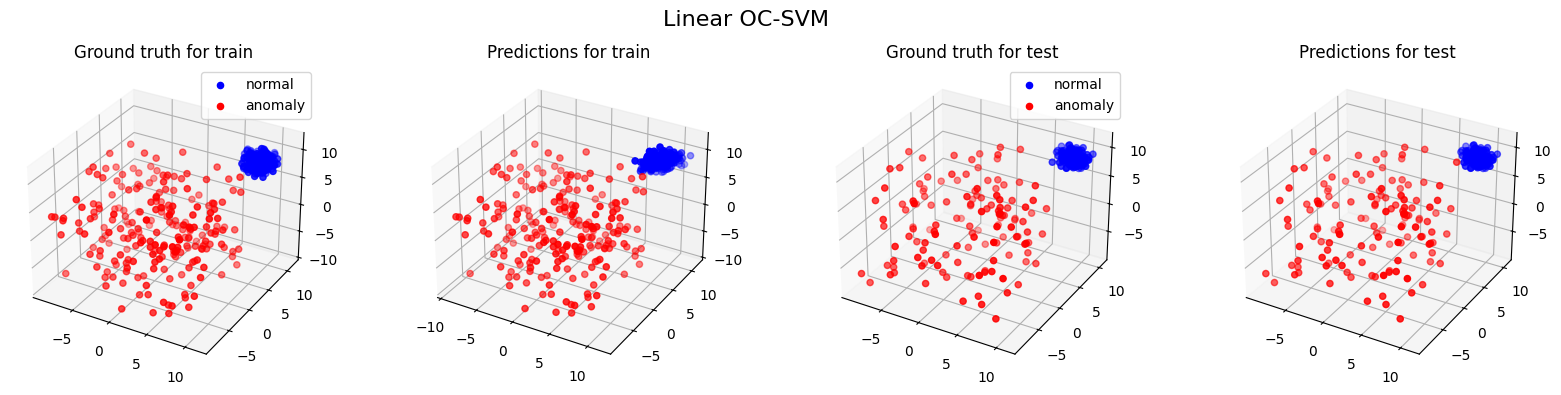

In [9]:
plot_3d_comparison(
    train_data,
    train_labels,
    test_data,
    test_labels,
    ocsvm_linear_train_predictions,
    ocsvm_linear_test_predictions,
    "Linear OC-SVM",
)

In [10]:
ocsvm_rbf = OCSVM(kernel='rbf', contamination=contamination)
ocsvm_rbf.fit(train_data)

# extract labels for training data
ocsvm_rbf_train_predictions = ocsvm_rbf.labels_
# extract score for training data
ocsvm_rbf_train_scores = ocsvm_rbf.decision_scores_

In [11]:
# compute predictions for the testing data
ocsvm_rbf_test_predictions = ocsvm_rbf.predict(test_data)
# compute scores for the testing data
ocsvm_rbf_test_scores = ocsvm_rbf.decision_function(test_data)

# compute balanced accuracy and ROC AUC score
ocsvm_rbf_test_ba = Metrics.balanced_accuracy(test_labels, ocsvm_rbf_test_predictions)
ocsvm_rbf_test_roc_auc = roc_auc_score(test_labels, ocsvm_rbf_test_scores)

print(f"Test BA for RBF OCSVM: {ocsvm_rbf_test_ba:.5f}")
print(f"Test ROC AUC for RBF OCSVM: {ocsvm_rbf_test_roc_auc:.5f}")

Test BA for RBF OCSVM: 0.99394
Test ROC AUC for RBF OCSVM: 1.00000


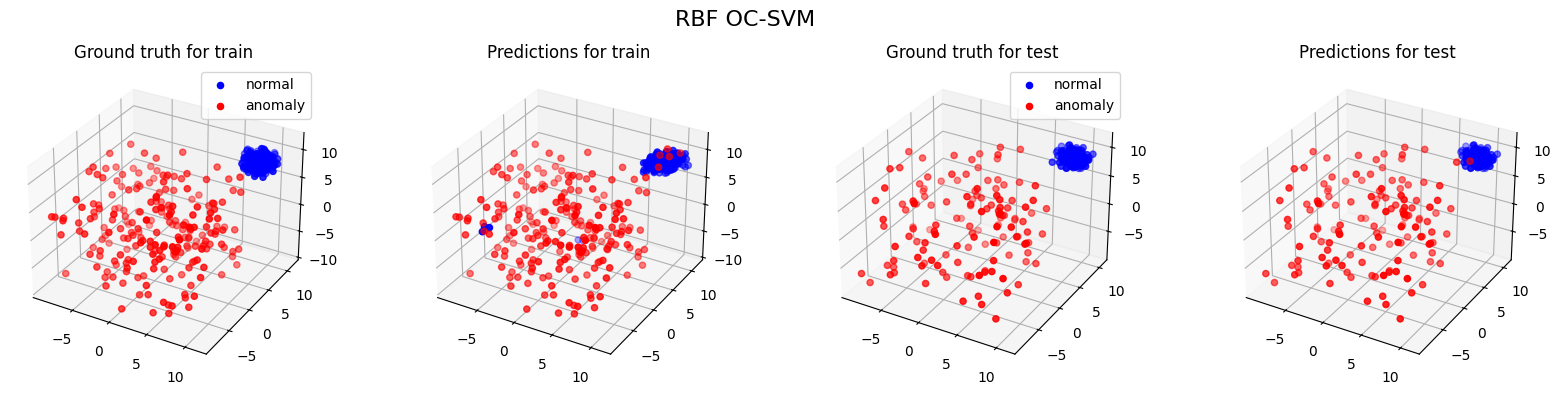

In [12]:
plot_3d_comparison(
    train_data,
    train_labels,
    test_data,
    test_labels,
    ocsvm_rbf_train_predictions,
    ocsvm_rbf_test_predictions,
    "RBF OC-SVM",
)

In [13]:
deep_svdd = DeepSVDD(n_features=n_features)
deep_svdd.fit(train_data)

# extract labels for training data
deep_svdd_train_predictions = deep_svdd.labels_
# extract score for training data
deep_svdd_train_scores = deep_svdd.decision_scores_

Epoch 1/100, Loss: 12.242708384990692
Epoch 2/100, Loss: 12.27497684955597
Epoch 3/100, Loss: 12.251036822795868
Epoch 4/100, Loss: 12.31669706106186
Epoch 5/100, Loss: 12.287252962589264
Epoch 6/100, Loss: 12.245538532733917
Epoch 7/100, Loss: 12.226550221443176
Epoch 8/100, Loss: 12.25053083896637
Epoch 9/100, Loss: 12.230712831020355
Epoch 10/100, Loss: 12.242542803287506
Epoch 11/100, Loss: 12.307015299797058
Epoch 12/100, Loss: 12.326615631580353
Epoch 13/100, Loss: 12.299463987350464
Epoch 14/100, Loss: 12.318953394889832
Epoch 15/100, Loss: 12.346225678920746
Epoch 16/100, Loss: 12.19237369298935
Epoch 17/100, Loss: 12.286705076694489
Epoch 18/100, Loss: 12.289217472076416
Epoch 19/100, Loss: 12.28538167476654
Epoch 20/100, Loss: 12.224184513092041
Epoch 21/100, Loss: 12.334693908691406
Epoch 22/100, Loss: 12.27842652797699
Epoch 23/100, Loss: 12.232575535774231
Epoch 24/100, Loss: 12.248823046684265
Epoch 25/100, Loss: 12.372764468193054
Epoch 26/100, Loss: 12.312586188316345
E

In [14]:
# compute predictions for the testing data
deep_svdd_test_predictions = deep_svdd.predict(test_data)
# compute scores for the testing data
deep_svdd_test_scores = deep_svdd.decision_function(test_data)

# compute balanced accuracy and ROC AUC score
deep_svdd_test_ba = Metrics.balanced_accuracy(test_labels, deep_svdd_test_predictions)
deep_svdd_test_roc_auc = roc_auc_score(test_labels, deep_svdd_test_scores)

print(f"Test BA for Deep SVDD: {deep_svdd_test_ba:.5f}")
print(f"Test ROC AUC for Deep SVDD: {deep_svdd_test_roc_auc:.5f}")

Test BA for Deep SVDD: 0.61852
Test ROC AUC for Deep SVDD: 0.67412


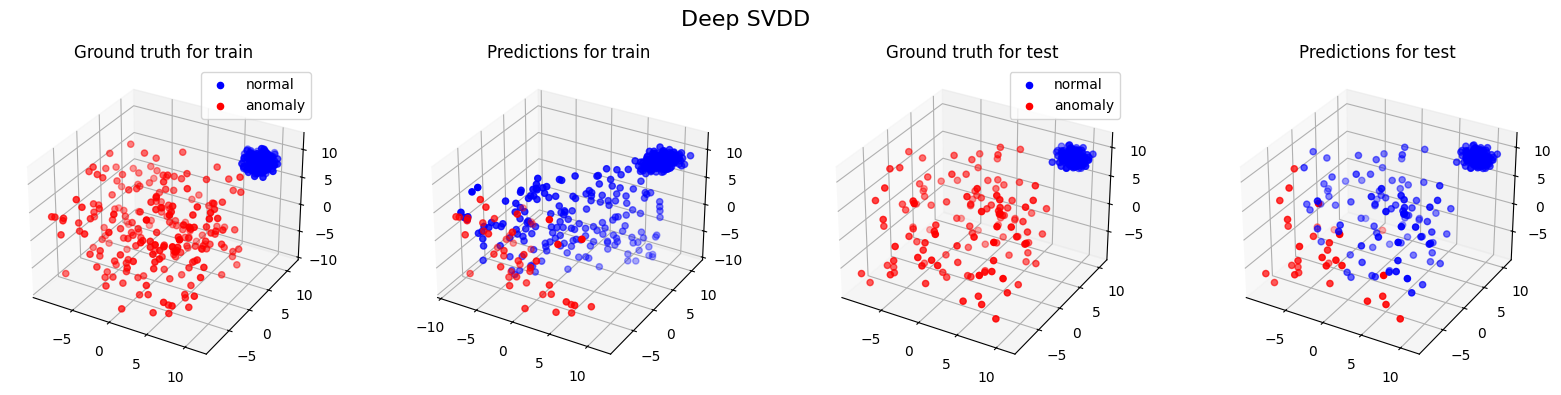

In [15]:
plot_3d_comparison(
    train_data,
    train_labels,
    test_data,
    test_labels,
    deep_svdd_train_predictions,
    deep_svdd_test_predictions,
    "Deep SVDD",
)

# **Exercise 2:**

1. In this exercise you will use the cardio dataset ([cardio dataset](https://odds.cs.stonybrook.edu/cardiotocogrpahy-dataset/)) from **ODDS**. You will split
the dataset into a training set consisting of 40% of the data and a testing
set.

2. You will use a cross-validation grid-search over a predefined map of possible parameters of **OneClassSVM** (*from sklearn.svm*) in order to find
the ones that offer best results. The map of possible parameters must
contain different kernels, different values for gamma parameter (for kernels that use it) and different values for the ν parameter (including the
contamination rate of train set).

3. **GridSearchCV** from sklearn.model selection will be used to perform the
grid-search over the training set using Balanced Accuracy as score. The
same metric will be reported for the model trained with the best parameters discovered by **GridSearchCV** (tested on the test set).

4. **GridSearchCV** will have to perform standardization; for this, it will
use a **Pipeline** from *sklearn.pipeline* that will perform standardization
using **StandardScaler** before fitting the **OneClassSVM** model.

5. You have to pay attention to the labels returned by **OneClassSVM** model
(*from sklearn*): -1 for outliers and 1 for inliers. If you want to convert
them to the pyod format you can use

$$label_{pyod} = (−1 ∗ label_{sklearn} + 1) / 2$$

6. Print the best parameters discovered by **GridSearchCV** and the balanced accuracy obtained by the model (trained with those parameters on
the entire training dataset) when evaluating the testing set.

In [ ]:
!wget -O cardio.mat https://www.dropbox.com/scl/fi/a1v7m3p1kbcnte1/cardio.mat?rlkey=84oboq7oqussys4iqi2b3kgv2&e=1&dl=1

--2024-11-25 16:45:37--  https://www.dropbox.com/scl/fi/a1v7m3p1kbcnte1/cardio.mat?rlkey=84oboq7oqussys4iqi2b3kgv2
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5d87dcb171c38d78a8601d7515.dl.dropboxusercontent.com/cd/0/inline/CfGk18bz9S7ozvehdcabhMIGn_NyDrFwWODNfqMJ-51CwW6gHWz65HGN0tx-NgwApO9HTAjicEN6FOeMt1iolAVN8v7jN-05NO5x--K7fZXnRteXMERZcNNZFiPIynEEcns/file# [following]
--2024-11-25 16:45:40--  https://uc5d87dcb171c38d78a8601d7515.dl.dropboxusercontent.com/cd/0/inline/CfGk18bz9S7ozvehdcabhMIGn_NyDrFwWODNfqMJ-51CwW6gHWz65HGN0tx-NgwApO9HTAjicEN6FOeMt1iolAVN8v7jN-05NO5x--K7fZXnRteXMERZcNNZFiPIynEEcns/file
Resolving uc5d87dcb171c38d78a8601d7515.dl.dropboxusercontent.com (uc5d87dcb171c38d78a8601d7515.dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to uc5d87dcb171c

In [ ]:
# load the dataset
cardio_dataset = loadmat("cardio.mat")
cardio_samples, cardio_labels = cardio_dataset["X"], cardio_dataset["y"]
cardio_contamination = round(np.sum(cardio_labels == 1) / np.sum(cardio_labels == 0), 5)

# split the dataset into train and test
cardio_train_samples, cardio_test_samples, cardio_train_labels, cardio_test_labels = train_test_split(cardio_samples, cardio_labels, test_size=0.4)

In [ ]:
"""
In pyod:                anomaly = 1,  normal = 0
In sklearn OneClassSVM: anomaly = -1, normal = 1
"""

def label_from_pyod_to_sklearn(labels: np.ndarray) -> np.ndarray:
    return np.where(labels == 1, -1, 1)

def label_from_sklearn_to_pyod(labels: np.ndarray) -> np.ndarray:
    return np.where(labels == -1, 1, 0)

In [ ]:
# transform the labels
# from pyod labels to sklearn labels
cardio_train_labels = label_from_pyod_to_sklearn(cardio_train_labels)
cardio_test_labels = label_from_pyod_to_sklearn(cardio_test_labels)

In [ ]:
parameters_grid = [
    {
        "kernel": ["linear"],
        "nu": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    },
    {
        "kernel": ["poly"],
        "degree": [2, 3, 4, 5, 6, 7, 8],
        "coef0": [0, 0.5, 1, 1.5, 2, 2.5, 3],
        "nu": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    },
    {
        "kernel": ["rbf"],
        "gamma": [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4],
        "nu": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    }
]
# define a balanced accuracy scorer
ba_scorer = make_scorer(Metrics.balanced_accuracy)
# define the pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ("grid_search", GridSearchCV(OneClassSVM(), parameters_grid, scoring=ba_scorer))])

In [ ]:
grid_search_pipeline = pipeline.fit(cardio_train_samples, cardio_train_labels)

In [ ]:
print(f"Best training parameters: {grid_search_pipeline.named_steps['grid_search'].best_params_}")
print(f"Best training balanced accuracy: {grid_search_pipeline.named_steps['grid_search'].best_score_:.5f}")

Best training parameters: {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.3}
Best training balanced accuracy: 0.88891


In [ ]:
best_ocsvm = OneClassSVM(**grid_search_pipeline.named_steps["grid_search"].best_params_)
best_ocsvm.fit(cardio_train_samples, cardio_train_labels)

best_ocsvm_test_predictions = best_ocsvm.predict(cardio_test_samples)
best_ocsvm_ba = Metrics.balanced_accuracy(cardio_test_labels, best_ocsvm_test_predictions)
print(f"Best OC-SVM balanced accuracy on test: {best_ocsvm_ba:.5f}")

Best OC-SVM balanced accuracy on test: 0.86267


# **Exercise 3:**

1. For this exercise we will need to download the *[shuttle dataset](https://odds.cs.stonybrook.edu/shuttle-dataset/)* from ODDS. Load the data
using **scipy.io.loadmat()** and use **train_test_split()** to split it into train
and test subsets (use 50% of data for testing). Normalize your data accordingly.

2. Fit **OCSVM** and **DeepSVDD** models (from pyod) using the training data and compute the balanced accuracy (BA) and the area under the curve for the testing data for both models (ROC AUC - using **sklearn.metrics.roc_auc_score**).

3. Use different architectures for **DeepSVDD** and compute the 2 aforementioned metrics for each case.


In [ ]:
# unfortunately, the download .mat file does not work,
# thus, the file need to be uploaded manually
!wget https://github.com/VladWero08/AnomalyDetection/blob/main/datasets/shuttle.mat

--2024-11-25 17:35:44--  https://github.com/VladWero08/AnomalyDetection/blob/main/datasets/shuttle.mat
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘shuttle.mat’

shuttle.mat             [ <=>                ] 283.45K  --.-KB/s    in 0.1s    

2024-11-25 17:35:45 (2.67 MB/s) - ‘shuttle.mat’ saved [290257]



In [ ]:
# load the shuttle dataset
shuttle_dataset = loadmat("shuttle.mat")
shuttle_samples, shuttle_labels = shuttle_dataset["X"], shuttle_dataset["y"]
shuttle_contamination = round(np.sum(shuttle_labels == 1) / len(shuttle_samples), 5)

In [ ]:
# standardize the samples
shuttle_samples = (shuttle_samples - np.mean(shuttle_samples, axis=0)) / np.std(shuttle_samples, axis=0)

In [ ]:
# split the dataset into train and test subsets
shuttle_train_samples, shuttle_test_samples, shuttle_train_labels, shuttle_test_labels = train_test_split(shuttle_samples, shuttle_labels, test_size=0.5)
shuttle_train_labels = np.squeeze(shuttle_train_labels, axis=1)
shuttle_test_labels = np.squeeze(shuttle_test_labels, axis=1)

In [ ]:
shuttle_ocsvm_rbf = OCSVM(kernel='rbf', contamination=shuttle_contamination)
shuttle_ocsvm_rbf.fit(shuttle_train_samples)

# extract labels for training data
shuttle_ocsvm_rbf_train_predictions = shuttle_ocsvm_rbf.labels_
# extract score for training data
shuttle_ocsvm_rbf_train_scores = shuttle_ocsvm_rbf.decision_scores_

In [ ]:
# compute predictions for the testing data
shuttle_ocsvm_rbf_test_predictions = shuttle_ocsvm_rbf.predict(shuttle_test_samples)
# compute scores for the testing data
shuttle_ocsvm_rbf_test_scores = shuttle_ocsvm_rbf.decision_function(shuttle_test_samples)

# compute balanced accuracy and ROC AUC score
shuttle_ocsvm_rbf_test_ba = Metrics.balanced_accuracy(shuttle_test_labels, shuttle_ocsvm_rbf_test_predictions)
shuttle_ocsvm_rbf_test_roc_auc = roc_auc_score(shuttle_test_labels, shuttle_ocsvm_rbf_test_scores)

print(f"Shuttle BA for RBF OCSVM: {shuttle_ocsvm_rbf_test_ba:.5f}")
print(f"Shuttle ROC AUC for RBF OCSVM: {shuttle_ocsvm_rbf_test_roc_auc:.5f}")

Shuttle BA for RBF OCSVM: 0.97657
Shuttle ROC AUC for RBF OCSVM: 0.99165


In [ ]:
shuttle_deep_svdd = DeepSVDD(n_features=shuttle_train_samples.shape[1], epochs=20)
shuttle_deep_svdd.fit(shuttle_train_samples)

# extract labels for training data
shuttle_deep_svdd_train_predictions = shuttle_deep_svdd.labels_
# extract score for training data
shuttle_deep_svdd_train_scores = shuttle_deep_svdd.decision_scores_

Epoch 1/20, Loss: 545.4952879846096
Epoch 2/20, Loss: 545.2768198847771
Epoch 3/20, Loss: 545.1809079796076
Epoch 4/20, Loss: 545.2252093628049
Epoch 5/20, Loss: 545.2028762176633
Epoch 6/20, Loss: 545.3803823441267
Epoch 7/20, Loss: 546.0303309708834
Epoch 8/20, Loss: 546.0456945374608
Epoch 9/20, Loss: 545.2749720290303
Epoch 10/20, Loss: 545.4807926341891
Epoch 11/20, Loss: 546.3771569356322
Epoch 12/20, Loss: 545.2867851629853
Epoch 13/20, Loss: 545.5875625014305
Epoch 14/20, Loss: 545.3310786262155
Epoch 15/20, Loss: 545.3446480333805
Epoch 16/20, Loss: 545.8227280378342
Epoch 17/20, Loss: 545.203788921237
Epoch 18/20, Loss: 545.2613293528557
Epoch 19/20, Loss: 545.6655451208353
Epoch 20/20, Loss: 545.2481765896082


In [ ]:
# compute predictions for the testing data
shuttle_deep_svdd_test_predictions = shuttle_deep_svdd.predict(shuttle_test_samples)
# compute scores for the testing data
shuttle_deep_svdd_test_scores = shuttle_deep_svdd.decision_function(shuttle_test_samples)

# compute balanced accuracy and ROC AUC score
shuttle_deep_svdd_test_ba = Metrics.balanced_accuracy(shuttle_test_labels, shuttle_deep_svdd_test_predictions)
shuttle_deep_svdd_test_roc_auc = roc_auc_score(shuttle_test_labels, shuttle_deep_svdd_test_scores)

print(f"Test BA for Deep SVDD: {shuttle_deep_svdd_test_ba:.5f}")
print(f"Test ROC AUC for Deep SVDD: {shuttle_deep_svdd_test_roc_auc:.5f}")

Test BA for Deep SVDD: 0.96446
Test ROC AUC for Deep SVDD: 0.98806


In [ ]:
hidden_neurons_sizes = [[32, 32], [32, 32, 32], [32, 32, 32, 32], [64, 64, 64, 64], [128, 128, 128, 128]]

for hidden_neurons in hidden_neurons_sizes:
    shuttle_deep_svdd = DeepSVDD(n_features=shuttle_train_samples.shape[1], epochs=20, hidden_neurons=hidden_neurons)
    shuttle_deep_svdd.fit(shuttle_train_samples)

    # extract labels for training data
    shuttle_deep_svdd_train_predictions = shuttle_deep_svdd.labels_
    # extract score for training data
    shuttle_deep_svdd_train_scores = shuttle_deep_svdd.decision_scores_

    # compute predictions for the testing data
    shuttle_deep_svdd_test_predictions = shuttle_deep_svdd.predict(shuttle_test_samples)
    # compute scores for the testing data
    shuttle_deep_svdd_test_scores = shuttle_deep_svdd.decision_function(shuttle_test_samples)

    # compute balanced accuracy and ROC AUC score
    shuttle_deep_svdd_test_ba = Metrics.balanced_accuracy(shuttle_test_labels, shuttle_deep_svdd_test_predictions)
    shuttle_deep_svdd_test_roc_auc = roc_auc_score(shuttle_test_labels, shuttle_deep_svdd_test_scores)

    print()
    print(f"Deep SVDD layers: {hidden_neurons}")
    print(f"Test BA for Deep SVDD: {shuttle_deep_svdd_test_ba:.5f}")
    print(f"Test ROC AUC for Deep SVDD: {shuttle_deep_svdd_test_roc_auc:.5f}")
    print()

Epoch 1/20, Loss: 672.4521496221423
Epoch 2/20, Loss: 672.6306006014347
Epoch 3/20, Loss: 673.0476450175047
Epoch 4/20, Loss: 672.8458982110023
Epoch 5/20, Loss: 672.5422741621733
Epoch 6/20, Loss: 672.4318785704672
Epoch 7/20, Loss: 672.7913485690951
Epoch 8/20, Loss: 672.4830233454704
Epoch 9/20, Loss: 672.9079148173332
Epoch 10/20, Loss: 672.4635922163725
Epoch 11/20, Loss: 672.4803396463394
Epoch 12/20, Loss: 672.6975647211075
Epoch 13/20, Loss: 673.2290904670954
Epoch 14/20, Loss: 672.4720319584012
Epoch 15/20, Loss: 674.0991891175508
Epoch 16/20, Loss: 673.2387797385454
Epoch 17/20, Loss: 673.8312766104937
Epoch 18/20, Loss: 672.73767080158
Epoch 19/20, Loss: 673.2366362959146
Epoch 20/20, Loss: 674.0287860631943

Deep SVDD layers: [32, 32]
Test BA for Deep SVDD: 0.89494
Test ROC AUC for Deep SVDD: 0.97422

Epoch 1/20, Loss: 71.29932499304414
Epoch 2/20, Loss: 67.43816593848169
Epoch 3/20, Loss: 73.40089446306229
Epoch 4/20, Loss: 70.13656424544752
Epoch 5/20, Loss: 70.3457128023